In [932]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sci
import pandas as pd
import seaborn as sns
import matplotlib

In [933]:
train = pd.read_csv("house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("house-prices-advanced-regression-techniques/test.csv")

In [934]:
data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], test.loc[:,'MSSubClass':'SaleCondition']))

In [935]:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
indeces = data.dtypes[data.dtypes != "object"].index

skewed_feats = train[indeces].apply(lambda x: sci.stats.skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

data[skewed_feats] = np.log1p(data[skewed_feats])

In [936]:
data = pd.get_dummies(data)

In [937]:
#filling NA's with the mean of the column:
data = data.fillna(data.mean())

In [938]:
#creating matrices for sklearn:
X_train = data[:train.shape[0]]
X_test = data[train.shape[0]:]
Y_train = train.SalePrice

In [939]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score

In [940]:
model_ridge = Ridge(alpha=.1)
model_ridge.fit(X_train, Y_train)

Ridge(alpha=0.1)

In [941]:
preds = model_ridge.predict(X_test)
preds = np.expm1(preds)

In [942]:
prediction = pd.DataFrame({"id":test.Id, "SalePrice":preds})
prediction.to_csv("ridge_sol.csv", index = False)

In [943]:
#After submitting to Kaggle, we get a RMSE of .1377

In [944]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, Y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [945]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 20, 30]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

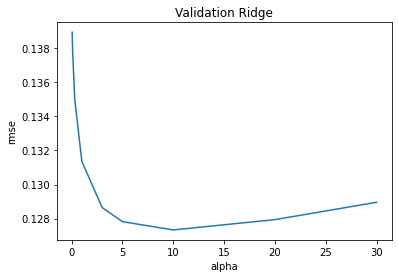

In [946]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation Ridge")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [947]:
alphasl = [.001, .0008, .0005, .0004, .0003, .0002]
cv_lasso = [rmse_cv(Lasso(alpha = alpha)).mean() 
            for alpha in alphasl]

Text(0, 0.5, 'rmse')

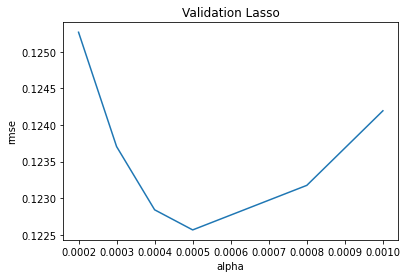

In [948]:
cv_lasso = pd.Series(cv_lasso, index = alphasl)
cv_lasso.plot(title = "Validation Lasso")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [949]:
# For a single LASSO Model, we can get to a RMSE of ~.138
# For a single Ridge Model, we can get to a RMSE of ~.141

In [950]:
models_lasso = [Lasso(alpha = alpha).fit(X_train, Y_train) for alpha in alphasl]

In [951]:
coefs = [pd.Series(models_lasso[i].coef_, index = X_train.columns) for i in range(0, len(alphasl))]

In [952]:
l0 = np.zeros_like(alphasl)
for i in range(0, len(alphasl)):
    l0[i] = sum(coefs[i] != 0)

In [953]:
print(l0)

[ 79.  90. 110. 121. 135. 158.]


Text(0, 0.5, 'number of coefs')

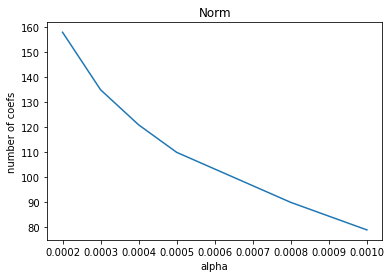

In [954]:
l0 = pd.Series(l0, index = alphasl)
l0.plot(title = "Norm")
plt.xlabel("alpha")
plt.ylabel("number of coefs")

In [955]:
predictions_lasso = [models_lasso[i].predict(X_train) for i in range(0, len(alphasl))]

In [956]:
X_train.loc[:]["lasso1"] = predictions_lasso[0]
X_train.loc[:]["lasso2"] = predictions_lasso[1]
X_train.loc[:]["lasso3"] = predictions_lasso[2]
X_train.loc[:]["lasso4"] = predictions_lasso[3]
X_train.loc[:]["lasso5"] = predictions_lasso[4]
X_train.loc[:]["lasso6"] = predictions_lasso[5]

In [957]:
model_ridge_es = Ridge(alpha=10)
model_ridge_es.fit(X_train, Y_train)

Ridge(alpha=10)

In [958]:
preds = model_ridge_es.predict(X_test)
preds = np.expm1(preds)

In [959]:
prediction = pd.DataFrame({"id":test.Id, "SalePrice":preds})
prediction.to_csv("ridge_es_sol.csv", index = False)

In [960]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, Y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [961]:
cv_ridge_es = rmse_cv(model_ridge_es).mean()
print(cv_ridge_es)

0.1273373466867077


In [962]:
# We can get down to a RMSE score of .134 which is better than both the LASSO and the Ridge Models

In [963]:
from xgboost import XGBRegressor

In [964]:
data_dmatrix = xgb.DMatrix(data=X_train,label=Y_train)

In [965]:
model = XGBRegressor(learning_rate=1, n_estimators=1000, max_depth=6,
                    min_child_weight=.8, gamma=0, subsample=0.8,
                    colsample_bytree=.8, nthread=4, objective='reg:squarederror'
                     )
model.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=1, max_delta_step=0, max_depth=6,
             min_child_weight=0.8, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, nthread=4, num_parallel_tree=1,
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [966]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = np.expm1(y_pred)

In [967]:
params = {"objective":"reg:squarederror",'colsample_bytree': .8,'learning_rate': .1,
                'max_depth': 6, 'alpha': 0}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=100,
                    num_boost_round=5000,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

In [968]:
cv_results.head(1000)

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,10.380132,0.000874,10.379370,0.096206
1,9.344456,0.000787,9.343646,0.096331
2,8.412309,0.000718,8.411510,0.092148
3,7.573347,0.000648,7.572970,0.088340
4,6.818244,0.000580,6.817646,0.085559
...,...,...,...,...
216,0.021461,0.000843,0.119023,0.045331
217,0.021341,0.000825,0.119003,0.045352
218,0.021213,0.000821,0.119005,0.045363
219,0.021083,0.000809,0.118982,0.045401


In [969]:
print((cv_results["test-rmse-mean"]).tail(1))

220    0.118971
Name: test-rmse-mean, dtype: float64


In [970]:
prediction = pd.DataFrame({"id":test.Id, "SalePrice":predictions})
prediction.to_csv("xgb_sol.csv", index = False)